In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from time import perf_counter
import os
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from tensorflow.keras.utils import plot_model  

In [ ]:
from google.colab import drive # type: ignore
drive.mount('/content/drive')

In [ ]:
## Defining batch specfications
batch_size = 100
img_height = 250
img_width = 250

In [ ]:
## loading training set
training_data = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/Accident-Detection-System-main/data/train',
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb'
)

Found 791 files belonging to 2 classes.


In [ ]:
## loading validation dataset
validation_data =  tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/Accident-Detection-System-main/data/val',
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb'
)

Found 98 files belonging to 2 classes.


In [ ]:
## loading testing dataset
testing_data = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/Accident-Detection-System-main/data/test',
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb'
)

Found 100 files belonging to 2 classes.


In [ ]:
testing_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 250, 250, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
class_names = training_data.class_names
class_names

['Accident', 'Non Accident']

In [ ]:
## Configuring dataset for performance
AUTOTUNE = tf.data.experimental.AUTOTUNE
training_data = training_data.cache().prefetch(buffer_size=AUTOTUNE)
testing_data = testing_data.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
## Defining Cnn
model = tf.keras.models.Sequential([
  layers.BatchNormalization(),
  layers.Conv2D(32, 3, activation='relu'), # Conv2D(f_size, filter_size, activation) # relu, sigmoid, softmax
  layers.MaxPooling2D(), # MaxPooling
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(len(class_names), activation= 'softmax')
])

model.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.build((None, 250, 250, 3))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ batch_normalization                  │ (None, 250, 250, 3)         │              12 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 248, 248, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 124, 124, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 122, 122, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 61, 61, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 59, 59, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 29, 29, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 27, 27, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 13, 13, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 43264)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      22,151,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │           1,026 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,541,134 (85.99 MB)

 Trainable params: 22,541,128 (85.99 MB)

 Non-trainable params: 6 (24.00 B)

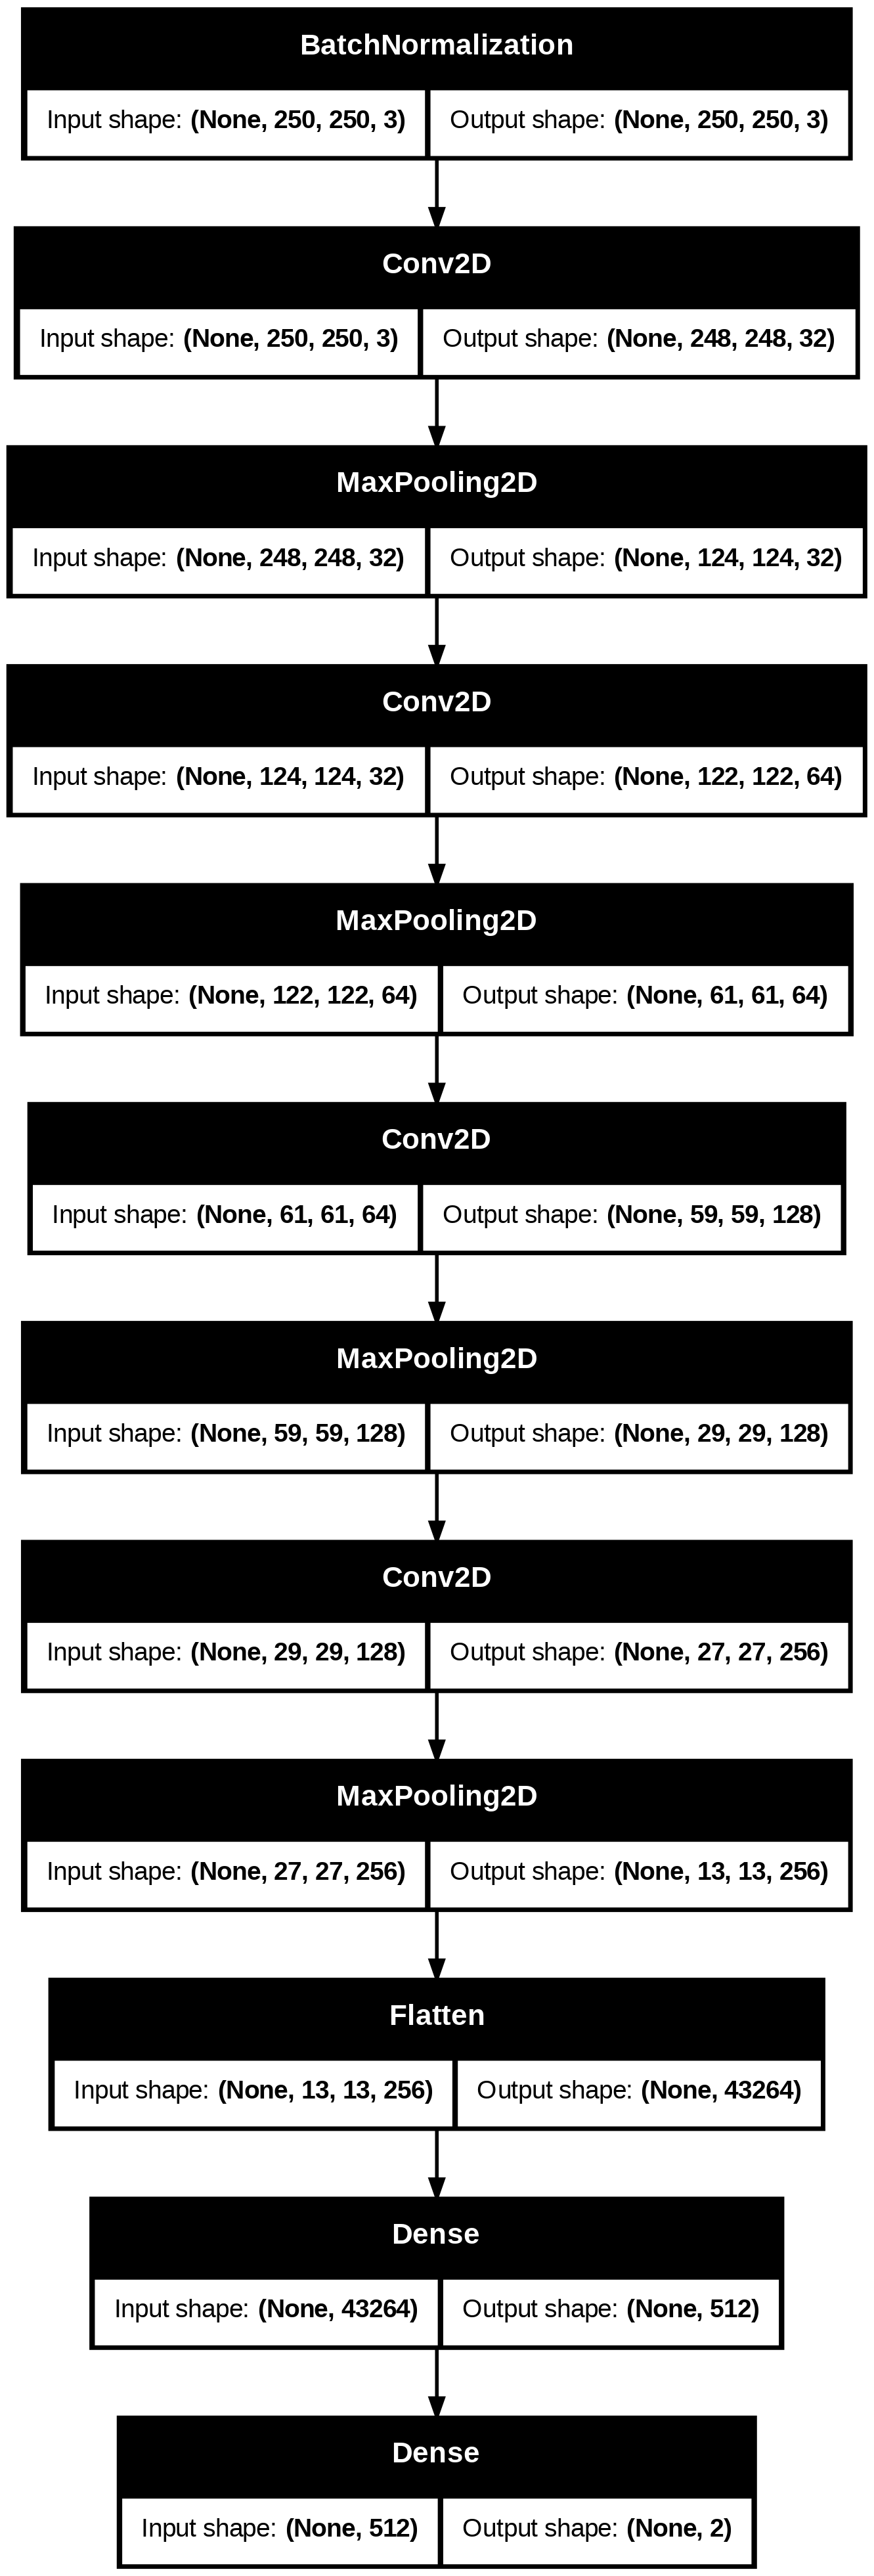

In [ ]:
plot_model(model, show_shapes=True)

In [ ]:
## lets train our CNN
checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
history = model.fit(training_data, validation_data=validation_data, epochs = 20, callbacks=callbacks_list)

Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.4998 - loss: 5.1076 
Epoch 1: val_accuracy improved from -inf to 0.53061, saving model to model_weights.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 209s 22s/step - accuracy: 0.5001 - loss: 4.9112 - val_accuracy: 0.5306 - val_loss: 0.7272
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.5397 - loss: 0.6846
Epoch 2: val_accuracy did not improve from 0.53061
8/8 ━━━━━━━━━━━━━━━━━━━━ 57s 291ms/step - accuracy: 0.5408 - loss: 0.6849 - val_accuracy: 0.5306 - val_loss: 0.8346
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.6397 - loss: 0.6465
Epoch 3: val_accuracy improved from 0.53061 to 0.68367, saving model to model_weights.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 556ms/step - accuracy: 0.6407 - loss: 0.6453 - val_accuracy: 0.6837 - val_loss: 0.5821
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.6556 - loss: 0.6038
Epoch 4: val_accuracy did not improve from 0.68367
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 329ms/step - accuracy: 0.6578 - loss: 0.6021 - val_accuracy: 0.6735 - val_loss: 0.5638
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.7165 - loss: 0.5516
Epoch 5: val_accuracy improved from 0.68367 to 0.74490, saving model to model_weights.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 430ms/step - accuracy: 0.7192 - loss: 0.5486 - val_accuracy: 0.7449 - val_loss: 0.6193
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.7719 - loss: 0.4811
Epoch 6: val_accuracy improved from 0.74490 to 0.83673, saving model to model_weights.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 507ms/step - accuracy: 0.7742 - loss: 0.4784 - val_accuracy: 0.8367 - val_loss: 0.4372
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.8225 - loss: 0.3849
Epoch 7: val_accuracy improved from 0.83673 to 0.87755, saving model to model_weights.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 413ms/step - accuracy: 0.8247 - loss: 0.3820 - val_accuracy: 0.8776 - val_loss: 0.3714
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.8535 - loss: 0.3192
Epoch 8: val_accuracy did not improve from 0.87755
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 385ms/step - accuracy: 0.8554 - loss: 0.3163 - val_accuracy: 0.8163 - val_loss: 0.4926
Epoch 9/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.8830 - loss: 0.2722
Epoch 9: val_accuracy did not improve from 0.87755
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 352ms/step - accuracy: 0.8848 - loss: 0.2693 - val_accuracy: 0.7959 - val_loss: 0.5496
Epoch 10/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.9185 - loss: 0.1869
Epoch 10: val_accuracy did not improve from 0.87755
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 293ms/step - accuracy: 0.9200 - loss: 0.1852 - val_accuracy: 0.8469 - val_loss: 0.3527
Epoch 11/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.9384 - loss: 0.1562
Epoch 11: val_accuracy improved from 0.87755 to 

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 408ms/step - accuracy: 0.9392 - loss: 0.1549 - val_accuracy: 0.8980 - val_loss: 0.2539
Epoch 12/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.9514 - loss: 0.1342
Epoch 12: val_accuracy did not improve from 0.89796
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 294ms/step - accuracy: 0.9516 - loss: 0.1330 - val_accuracy: 0.8367 - val_loss: 0.5031
Epoch 13/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.9516 - loss: 0.1141
Epoch 13: val_accuracy did not improve from 0.89796
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 320ms/step - accuracy: 0.9525 - loss: 0.1128 - val_accuracy: 0.8776 - val_loss: 0.4168
Epoch 14/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.9636 - loss: 0.0767
Epoch 14: val_accuracy did not improve from 0.89796
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 334ms/step - accuracy: 0.9642 - loss: 0.0766 - val_accuracy: 0.8980 - val_loss: 0.3633
Epoch 15/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.9655 - loss: 0.0865
Epoch 15: val_accuracy did not improve from 

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 414ms/step - accuracy: 0.9815 - loss: 0.0671 - val_accuracy: 0.9286 - val_loss: 0.2756
Epoch 18/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.9810 - loss: 0.0489
Epoch 18: val_accuracy did not improve from 0.92857
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 932ms/step - accuracy: 0.9811 - loss: 0.0493 - val_accuracy: 0.9082 - val_loss: 0.3407
Epoch 19/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.9702 - loss: 0.0838
Epoch 19: val_accuracy did not improve from 0.92857
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 381ms/step - accuracy: 0.9708 - loss: 0.0821 - val_accuracy: 0.8571 - val_loss: 0.3709
Epoch 20/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.9734 - loss: 0.0682
Epoch 20: val_accuracy did not improve from 0.92857
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 297ms/step - accuracy: 0.9738 - loss: 0.0674 - val_accuracy: 0.8980 - val_loss: 0.2512


In [ ]:
###### serialize model structure to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

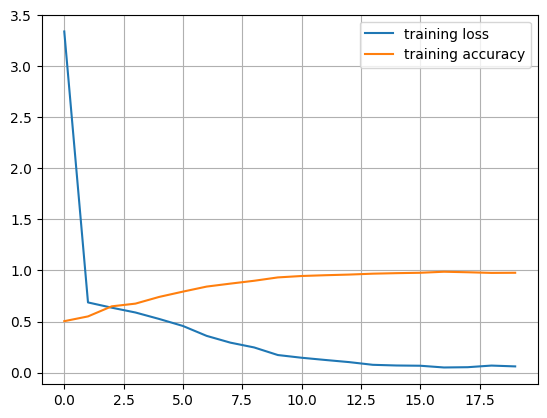

In [ ]:
## stats on training data
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['accuracy'], label = 'training accuracy')
plt.grid(True)
plt.legend()

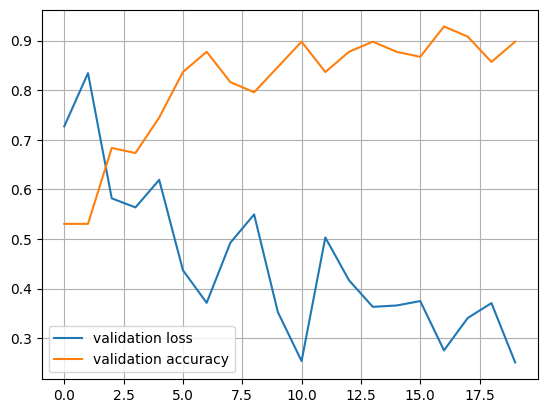

In [ ]:
## stats on training data
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.plot(history.history['val_accuracy'], label = 'validation accuracy')
plt.grid(True)
plt.legend()

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 287ms/step


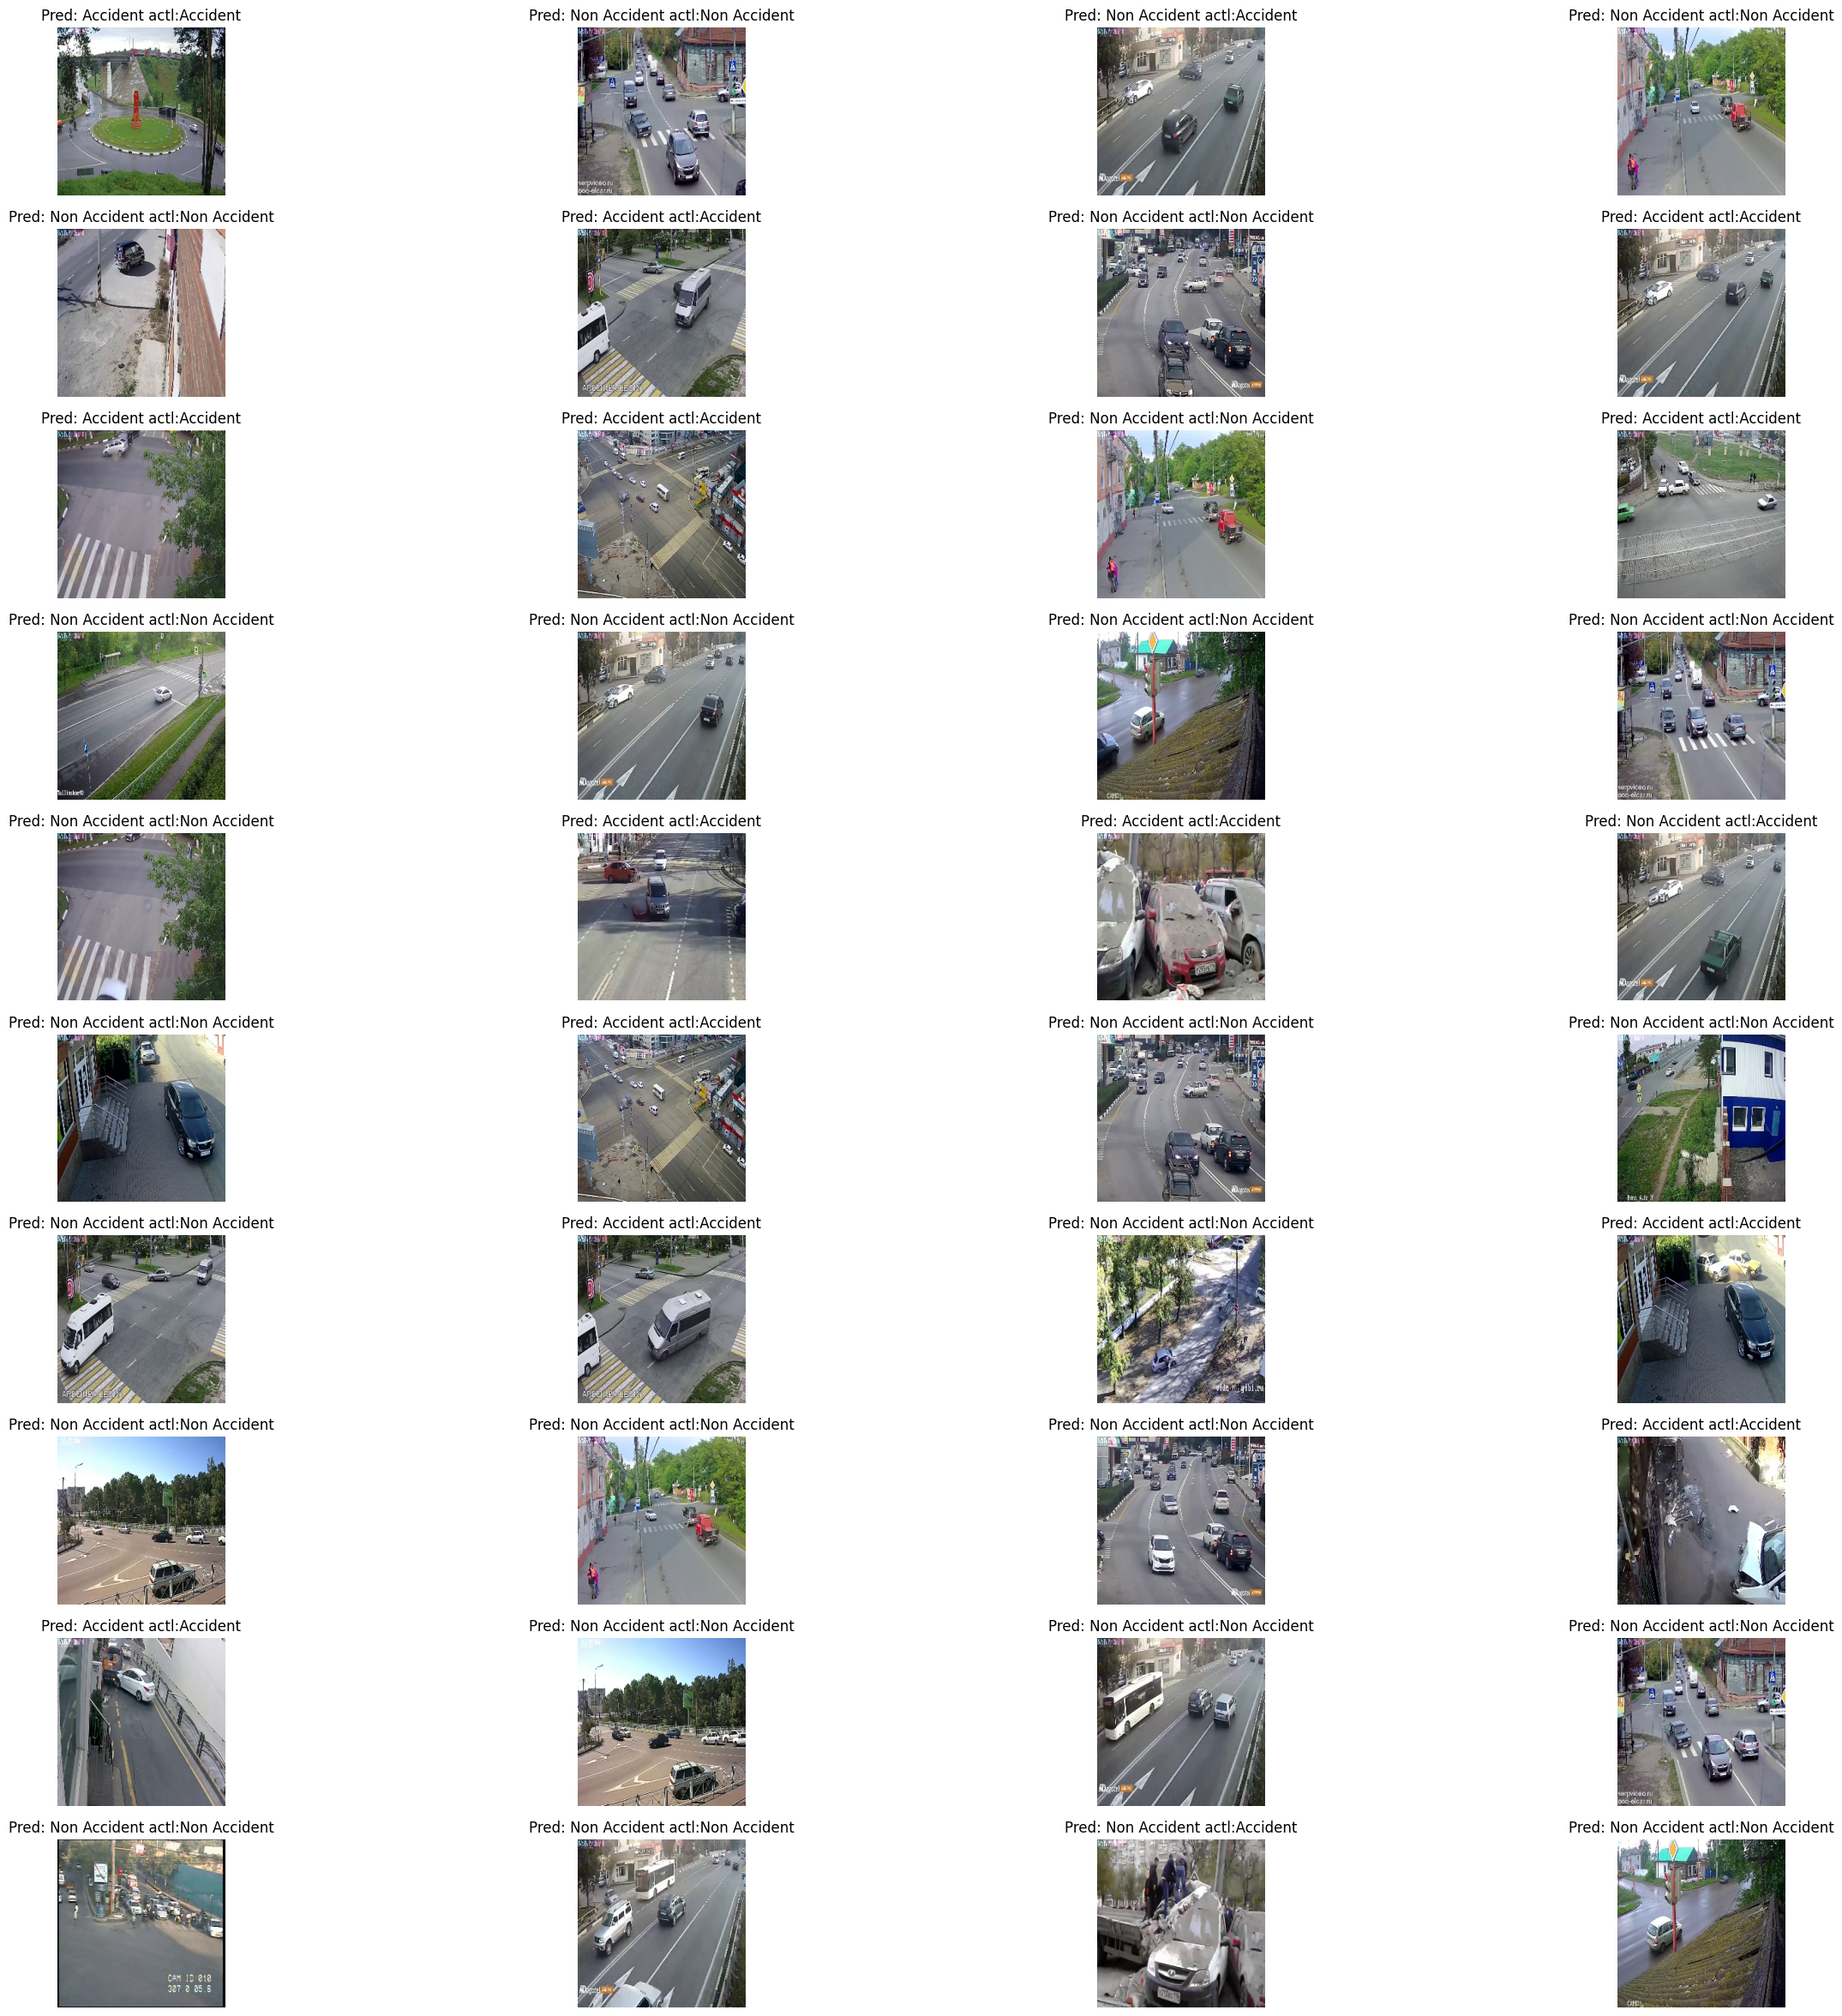

In [ ]:
## lets vizualize results on testing data
AccuracyVector = []
plt.figure(figsize=(30, 30))
for images, labels in testing_data.take(1):
    predictions = model.predict(images)
    predlabel = []
    prdlbl = []

    for mem in predictions:
        predlabel.append(class_names[np.argmax(mem)])
        prdlbl.append(np.argmax(mem))

    AccuracyVector = np.array(prdlbl) == labels
    for i in range(40):
        ax = plt.subplot(10, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title('Pred: '+ predlabel[i]+' actl:'+class_names[labels[i]] )
        plt.axis('off')
        plt.grid(True)

In [ ]:
import cv2
import numpy as np
import webbrowser
import os
import time
from keras.models import model_from_json  # type: ignore
from PIL import Image, ImageSequence
from IPython.display import display, HTML
import requests
from twilio.rest import Client  # type: ignore # Twilio SDK for sending SMS




# Send SMS once flag
notification_sent = False

# Define Accident Detection Model
class AccidentDetectionModel:
    class_nums = ['Accident', "No Accident"]

    def __init__(self, model_json_file, model_weights_file):
        with open(model_json_file, "r") as json_file:
            loaded_model_json = json_file.read()
            self.loaded_model = model_from_json(loaded_model_json)

        self.loaded_model.load_weights(model_weights_file)
        self.loaded_model.make_predict_function()

    def predict_accident(self, img):
        self.preds = self.loaded_model.predict(img)
        return AccidentDetectionModel.class_nums[np.argmax(self.preds)], self.preds

# Load the trained model
model = AccidentDetectionModel("./model.json", "./model_weights.h5")

geo_fetched = False

def get_geolocation():
    """Fetch geolocation via browser and Flask server."""
    try:
        print("🌐 Opening browser for accurate location access...")
        webbrowser.open("http://localhost:5000", new=1)
        for _ in range(30):
            response = requests.get("http://localhost:5000/get_coords")
            if response.status_code == 200:
                data = response.json()
                if data['latitude'] and data['longitude']:
                    latlng = [data['latitude'], data['longitude']]
                    print("📍 Accurate Geolocation obtained via browser:", latlng)
                    return latlng
            time.sleep(0.5)
        print("⚠️ Timeout: Did not receive accurate location in time.")
        return None
    except Exception as e:
        print("❌ Error getting accurate geolocation:", e)
        return None

def send_sms_notification():
    """Send SMS using Twilio."""
    try:
        client = Client(TWILIO_ACCOUNT_SID, TWILIO_AUTH_TOKEN)
        message = client.messages.create(
            to=TO_PHONE_NUMBER,
            messaging_service_sid=TWILIO_SERVICE_SID,
            body="🚨 The accident has occurred for your loved one."
        )
        print("📱 SMS sent successfully. SID:", message.sid)
    except Exception as e:
        print("❌ Failed to send SMS:", e)

def process_frame(frame):
    """Processes a frame, predicts accidents, and overlays results."""
    global geo_fetched, notification_sent

    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    roi = cv2.resize(rgb_frame, (250, 250))

    pred, prob = model.predict_accident(roi[np.newaxis, :, :, :])
    prob_value = round(prob[0][0] * 100, 2)

    cv2.putText(frame, f"{pred} {prob_value}%", (20, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

    # Trigger SMS only once when accident = 100%
    if pred == "Accident" and prob_value == 100.0 and not notification_sent:
        print("🚨 Accident Detected with 100% Confidence!")
        send_sms_notification()
        notification_sent = True

    # Always fetch geolocation once
    if not geo_fetched:
        print("📡 Fetching geolocation...")
        location = get_geolocation()
        if location:
            print(f"📍 Geolocation (Latitude, Longitude): {location}")
        else:
            print("⚠️ Could not retrieve geolocation.")
        geo_fetched = True

    return frame

def start_application(video_source):
    """Processes and plays video with accident detection results."""
    if video_source.lower().endswith(('.png', '.jpg', '.jpeg')):
        frame = cv2.imread(video_source)
        if frame is None:
            print("❌ Error: Could not read image file.")
            return
        processed_frame = process_frame(frame)
        cv2.imshow("Processed Frame", processed_frame)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

    elif video_source.lower().endswith('.gif'):
        gif = Image.open(video_source)
        for frame in ImageSequence.Iterator(gif):
            frame = np.array(frame.convert("RGB"))
            frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
            processed_frame = process_frame(frame)
            cv2.imshow("Processed Frame", processed_frame)
            if cv2.waitKey(100) & 0xFF == ord('q'):
                break
        cv2.destroyAllWindows()

    else:
        video = cv2.VideoCapture(0 if video_source == "0" else video_source)
        if not video.isOpened():
            print("❌ Error: Could not open video source.")
            return

        frame_width = int(video.get(3))
        frame_height = int(video.get(4))
        fps = int(video.get(cv2.CAP_PROP_FPS)) or 24



#nothing to see here

        output_path = "output6.mp4"

        fourcc = cv2.VideoWriter_fourcc(*"mp4v")
        out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

        print("🎥 Processing video...")
        while True:
            ret, frame = video.read()
            if not ret:
                break

            processed_frame = process_frame(frame)
            out.write(processed_frame)

        video.release()
        out.release()
        cv2.destroyAllWindows()
        print("✅ Video processing complete. Displaying video...")

        display(HTML(f"""
            <video width="640" height="360" controls>
                <source src="{output_path}" type="video/mp4">
            </video>
        """))

if __name__ == "__main__":
    video_source = input("Enter image/GIF/video file path (or '0' for webcam): ").strip()
    start_application(video_source)


🎥 Processing video...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
📡 Fetching geolocation...
🌐 Opening browser for accurate location access...
📍 Accurate Geolocation obtained via browser: [12.25372054542474, 76.61861587696635]
📍 Geolocation (Latitude, Longitude): [12.25372054542474, 76.61861587696635]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
🚨 Accident Detected with 100% Confidence!
📱 SMS sent successfully. SID: SM70e104727b3d71189abb5dab8c825c89
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s